In [1]:
import gc

from facenet_pytorch import MTCNN, InceptionResnetV1, fixed_image_standardization, training
import torch
from torch.utils.data import DataLoader, SubsetRandomSampler
from torch import optim
from torch.optim.lr_scheduler import MultiStepLR
from torchvision import datasets, transforms
import numpy as np

In [2]:
# Cuda maintenance
gc.collect()
torch.cuda.empty_cache()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Torch device: ", device)

Torch device:  cuda


# Implement image classifier for 5 classes

---

https://lms.skillfactory.ru/courses/course-v1:SkillFactory+MISISDS22p3s+SEPT22/courseware/c50cb25f34ee4c37ac16876299d21bb5/4a46cc1c667b44de8a6c01215879e481/1?activate_block_id=block-v1%3ASkillFactory%2BMISISDS22p3s%2BSEPT22%2Btype%40vertical%2Bblock%40698440eac17743859050bfdcf82a7286


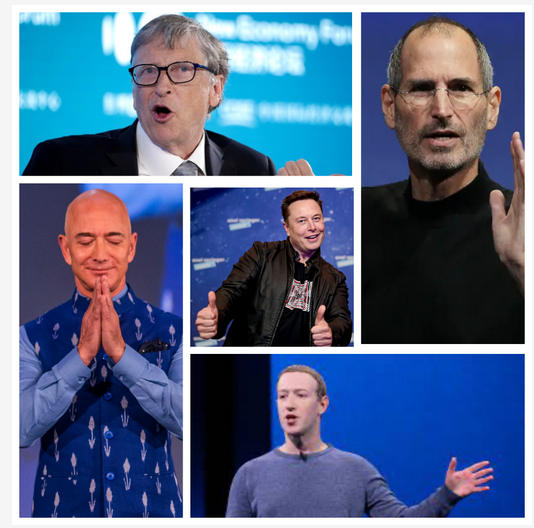


The task is to implement an image classifier using any pretrained model given test and validation databases.

## Load and visualize data

---


In [3]:
train_data_path = '/home/rpc/Desktop/FaceRecognition/data/train'
test_data_path = '/home/rpc/Desktop/FaceRecognition/data/valid'

In [4]:
# Dataset paramaters

BATCH_SIZE = 32
WORKERS = 0
IMG_SIZE = 160

In [5]:
train_dataset = datasets.ImageFolder(train_data_path, transform=transforms.Resize((IMG_SIZE, IMG_SIZE)))
visu_train_loader = DataLoader(
    train_dataset,
    num_workers=WORKERS,
    batch_size=BATCH_SIZE,
    collate_fn=training.collate_pil,
    shuffle=True 
)

In [6]:
idx_to_class = dict()

for key, value in train_dataset.class_to_idx.items():
    idx_to_class[value] = key

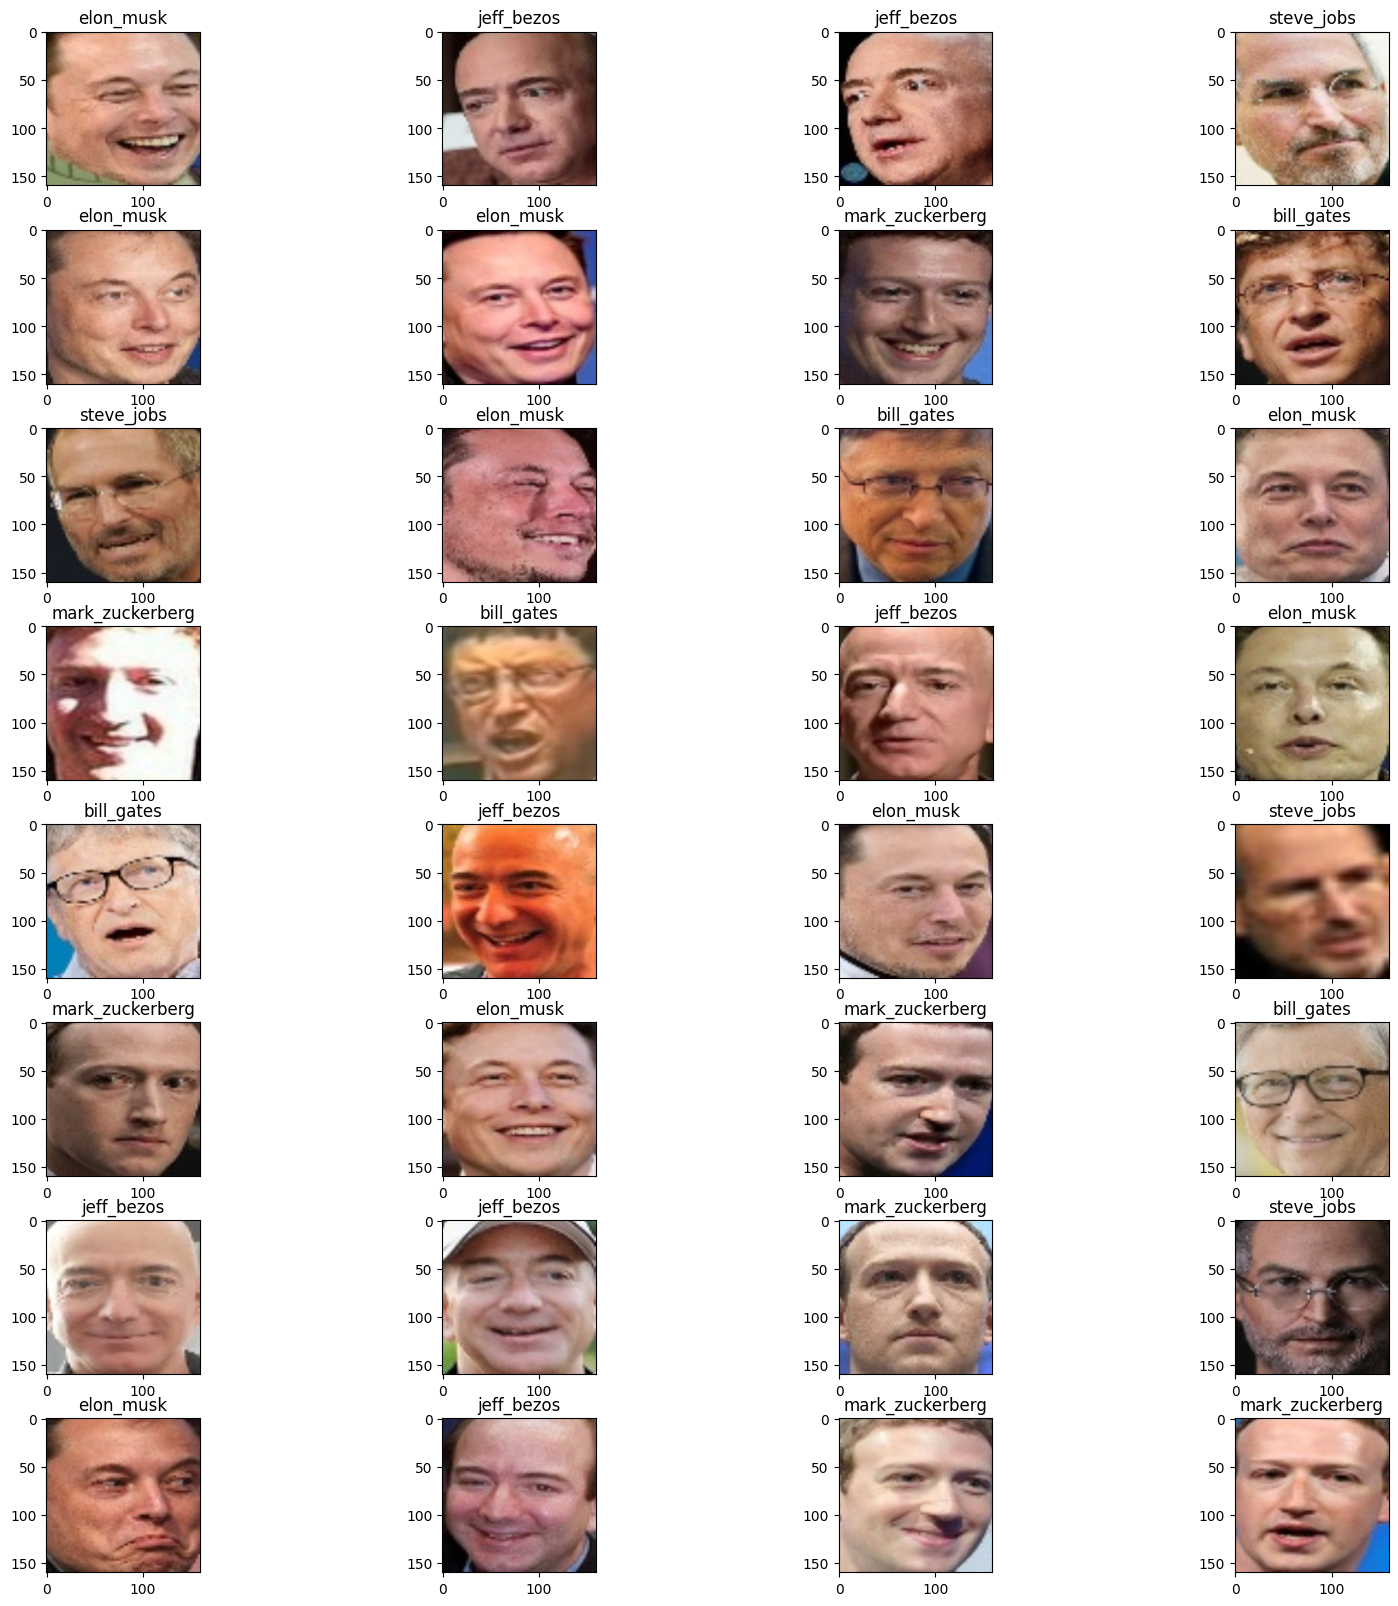

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline 

ncols=4
nrows=int(BATCH_SIZE/ncols)

images, labels = next(iter(visu_train_loader))

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 16))
fig.tight_layout()

for i in range(nrows):
    for j in range(ncols):
        idx = i*ncols + j
        if idx >= len(images):
            break
        ax[i][j].imshow(images[idx])
        ax[i][j].set_title(idx_to_class[labels[idx]])
    
plt.show()

## Finetune pretrained model

---

``InceptionResnetV1`` pretrained model from ``facenet-pytorch`` module (https://github.com/timesler/facenet-pytorch)
was chosen. It was trained on ``VGGFace2`` dataset (https://github.com/cydonia999/VGGFace2-pytorch).


In [8]:
help(InceptionResnetV1)

Help on class InceptionResnetV1 in module facenet_pytorch.models.inception_resnet_v1:

class InceptionResnetV1(torch.nn.modules.module.Module)
 |  InceptionResnetV1(pretrained=None, classify=False, num_classes=None, dropout_prob=0.6, device=None)
 |  
 |  Inception Resnet V1 model with optional loading of pretrained weights.
 |  
 |  Model parameters can be loaded based on pretraining on the VGGFace2 or CASIA-Webface
 |  datasets. Pretrained state_dicts are automatically downloaded on model instantiation if
 |  requested and cached in the torch cache. Subsequent instantiations use the cache rather than
 |  redownloading.
 |  
 |  Keyword Arguments:
 |      pretrained {str} -- Optional pretraining dataset. Either 'vggface2' or 'casia-webface'.
 |          (default: {None})
 |      classify {bool} -- Whether the model should output classification probabilities or feature
 |          embeddings. (default: {False})
 |      num_classes {int} -- Number of output classes. If 'pretrained' is s

In [7]:
resnet_model = InceptionResnetV1(classify=True,
    pretrained='vggface2',
    num_classes=len(train_dataset.class_to_idx)).to(device)

In [8]:
from FaceRecognition.mtcnn_dataset_wrapper import MTCNNDatasetWrapper

In [9]:
optimizer = optim.Adam(resnet_model.parameters(), lr=0.001)
scheduler = MultiStepLR(optimizer, [5, 10])

transformations = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    np.float32,
    transforms.ToTensor(),
    fixed_image_standardization
])

#train_dataset = datasets.ImageFolder(train_data_path, transform=transformations)
train_dataset = MTCNNDatasetWrapper(train_data_path, device=device, return_boxes=False)

In [10]:
from sklearn.model_selection import train_test_split

train_idx, validation_idx = train_test_split(list(range(len(train_dataset))),
                                             test_size=0.3, random_state=42, shuffle=True)


In [11]:
def collate_pil_debug(x): 
    out_x, out_y, out_z = [], [], [] 
    for xx, yy, zz in x: 
        out_x.append(xx) 
        out_y.append(yy) 
        out_z.append(zz) 
    return out_x, out_y, out_z

train_loader = DataLoader(
    train_dataset,
    num_workers=WORKERS,
    batch_size=BATCH_SIZE,
    sampler=SubsetRandomSampler(train_idx)
)

val_loader = DataLoader(
    train_dataset,
    num_workers=WORKERS,
    batch_size=BATCH_SIZE,
    sampler=SubsetRandomSampler(validation_idx)
)

In [12]:
loss_fn = torch.nn.CrossEntropyLoss()
metrics = {
    'fps': training.BatchTimer(),
    'acc': training.accuracy
}

In [13]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter()
writer.iteration, writer.interval = 0, 10

EPOCHS = 8


print('\nBefore fine-tuning')
print('-' * 10)
resnet_model.eval()
training.pass_epoch(
    resnet_model, loss_fn, val_loader,
    batch_metrics=metrics, show_running=True, device=device,
    writer=writer
)

for epoch in range(EPOCHS):
    print('\nEpoch {}/{}'.format(epoch + 1, EPOCHS))
    print('-' * 10)

    resnet_model.train()
    training.pass_epoch(
        resnet_model, loss_fn, train_loader, optimizer, scheduler,
        batch_metrics=metrics, show_running=True, device=device,
        writer=writer
    )

    resnet_model.eval()
    training.pass_epoch(
        resnet_model, loss_fn, val_loader,
        batch_metrics=metrics, show_running=True, device=device,
        writer=writer
    )

writer.close()


Before fine-tuning
----------
Valid |    29/29   | loss:    2.1274 | fps:   75.5923 | acc:    0.0194   

Epoch 1/8
----------
Train |    66/66   | loss:    0.3789 | fps:   66.9438 | acc:    0.8793   
Valid |    29/29   | loss:    0.2419 | fps:   77.2711 | acc:    0.9267   

Epoch 2/8
----------
Train |    66/66   | loss:    0.1458 | fps:   66.6632 | acc:    0.9550   
Valid |    29/29   | loss:    0.1488 | fps:   76.2484 | acc:    0.9623   

Epoch 3/8
----------
Train |    66/66   | loss:    0.0969 | fps:   66.1825 | acc:    0.9691   
Valid |    29/29   | loss:    0.2928 | fps:   76.2920 | acc:    0.9095   

Epoch 4/8
----------
Train |    66/66   | loss:    0.0690 | fps:   67.7080 | acc:    0.9801   
Valid |    29/29   | loss:    0.1392 | fps:   76.0532 | acc:    0.9569   

Epoch 5/8
----------
Train |    66/66   | loss:    0.0474 | fps:   68.7497 | acc:    0.9838   
Valid |    29/29   | loss:    0.0695 | fps:   76.2717 | acc:    0.9838   

Epoch 6/8
----------
Train |    66/66   | lo

In [14]:
#test_dataset = datasets.ImageFolder(test_data_path, transform=transformations)
test_dataset = MTCNNDatasetWrapper(test_data_path, device=device, return_boxes=False)

test_loader = DataLoader(
    test_dataset,
    num_workers=WORKERS,
    batch_size=BATCH_SIZE
)

In [15]:
resnet_model.eval()

y_true = []
y_predicted = []

misclassified_img = []

for batch_idx, (x, y) in enumerate(test_loader):
    scores = resnet_model(x.cuda())
    softmax = torch.exp(scores).cpu()
    prob = list(softmax.detach().numpy())
    predictions = np.argmax(prob, axis=1)
    y_true.append(y.data)
    y_predicted.append(predictions)
    diff = [a_i - b_i for a_i, b_i in zip(y.data, predictions)]
    misclassified = [i for i, e in enumerate(diff) if e != 0]
    for idx in misclassified:
        misclassified_img.append((x[idx], predictions[idx], y.data[idx]))

In [ ]:
y_true = [item for sublist in y_true for item in sublist]
y_predicted = [item for sublist in y_predicted for item in sublist]

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


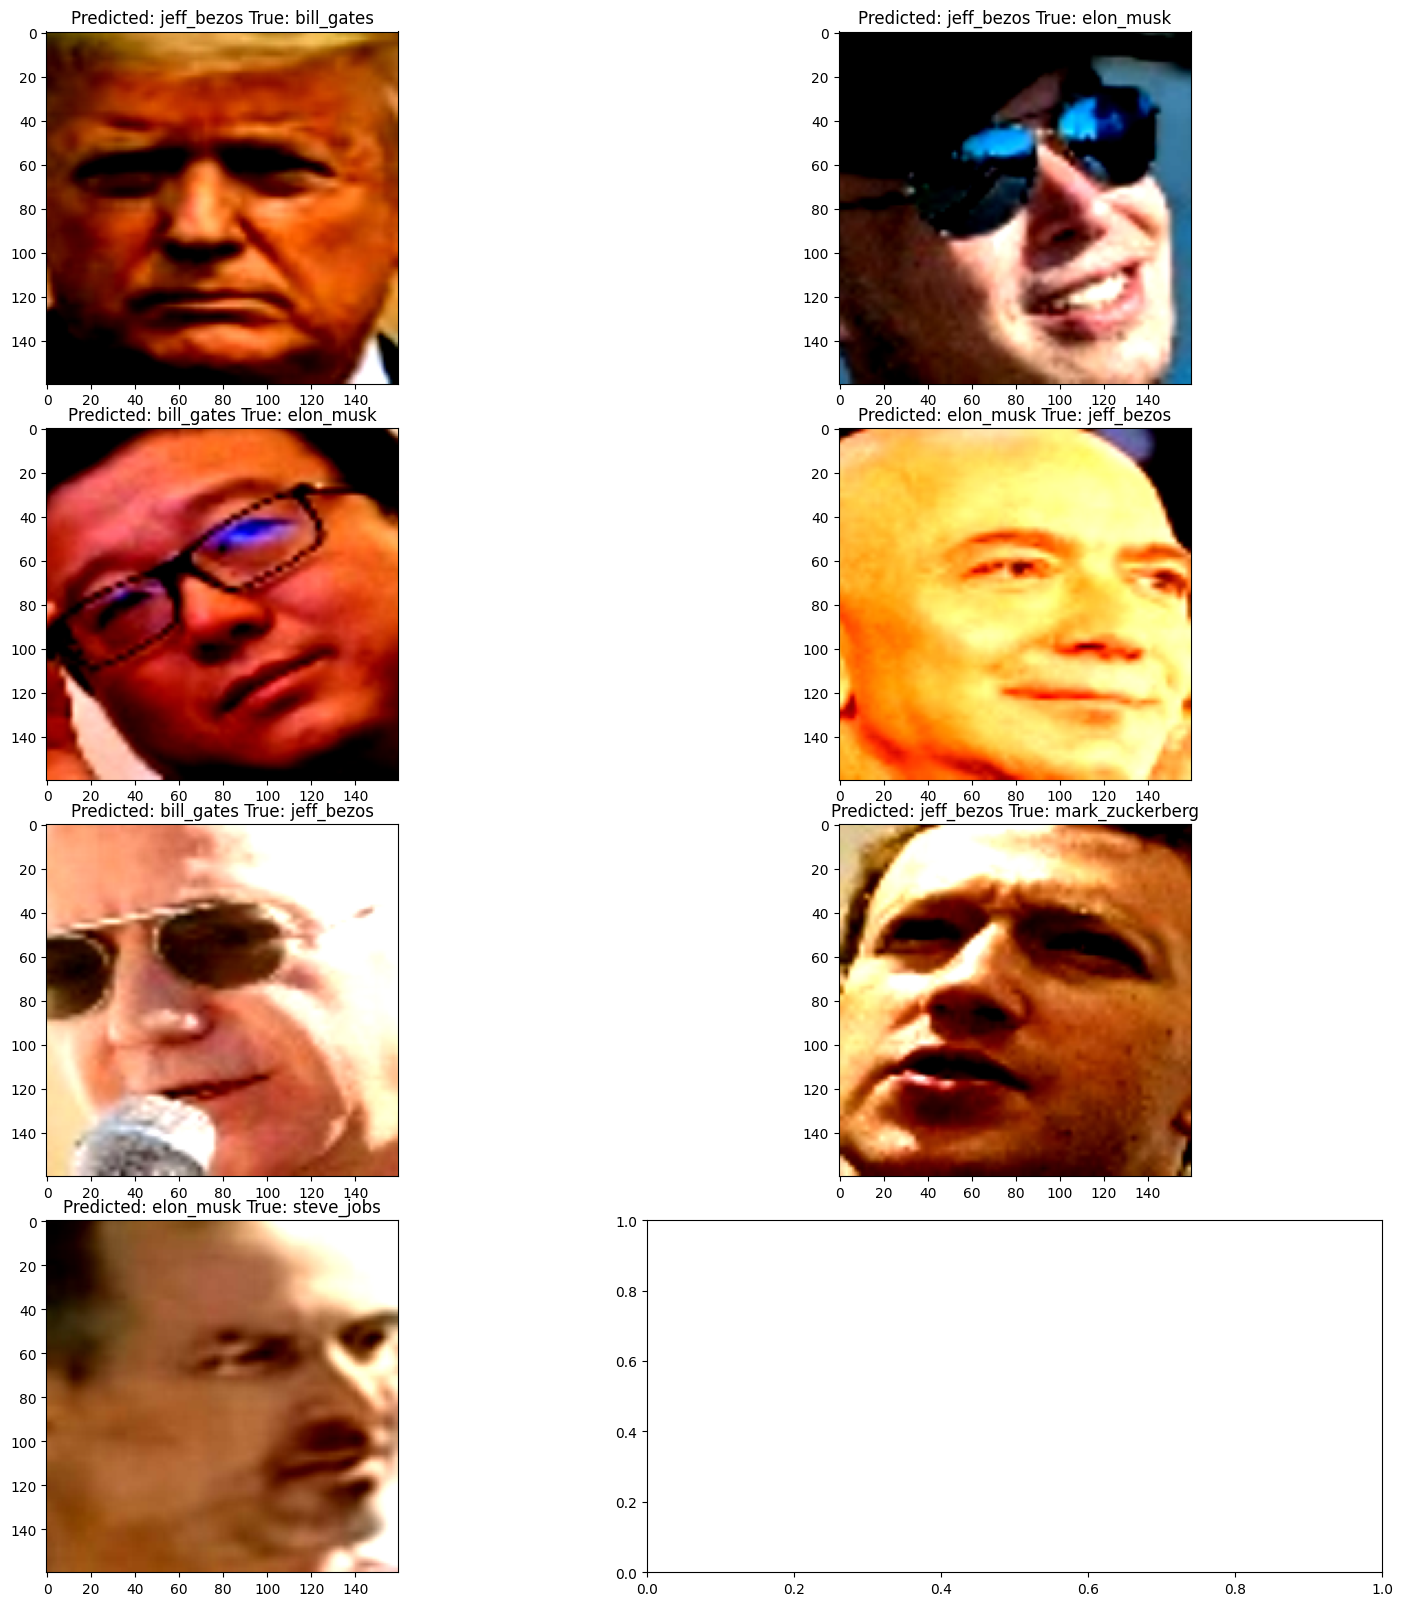

In [25]:
import math

ncols=2
nrows=math.ceil(len(misclassified_img)/ncols)

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 16))
fig.tight_layout()

denormalize = transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                std = [ 1., 1., 1. ])

for i in range(nrows):
    for j in range(ncols):
        idx = i*ncols + j
        if idx >= len(misclassified_img):
            break
        ax[i][j].imshow(denormalize(misclassified_img[idx][0]).permute(1, 2, 0))
        predicted_label = idx_to_class[misclassified_img[idx][1]]
        true_label = idx_to_class[misclassified_img[idx][2].item()]
        ax[i][j].set_title("Predicted: "+predicted_label+" True: "+true_label)
    
plt.show()

Accuracy: 0.9923413566739606


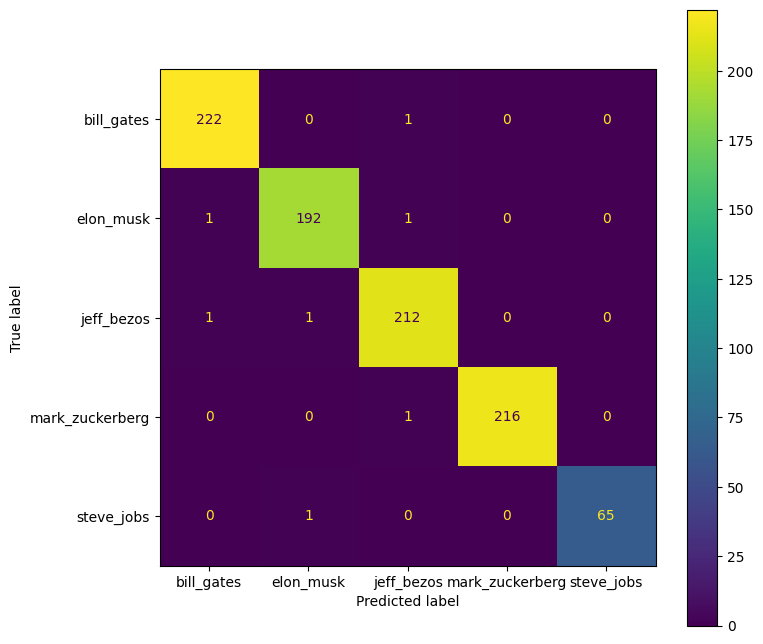

In [24]:
from sklearn import metrics 
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_true, y_predicted)
print("Accuracy: " + str(accuracy))

confusion_matrix = metrics.confusion_matrix(y_true, y_predicted)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix,
                                            display_labels = list(train_dataset.class_to_idx.keys()))

fig, ax = plt.subplots(figsize=(8,8))

cm_display.plot(ax=ax)
plt.show()

## Detect faces and crop images before fine-tuning

---

For detecting faces we will use ``MTCNN face detector`` from ``facenet_pytorch`` module (https://github.com/timesler/facenet-pytorch/blob/master/models/mtcnn.py). This model detects all faces in PIL image and return bounding boxes and probabilities as well.

The prediction accuracy is already very high, we have only two misclassified images.
And faces are already cropped as they should be.
So adding ``MTCNN face detector`` to the pipeline is just for educational purposes.


In [26]:
from FaceRecognition.mtcnn_dataset_wrapper import MTCNNDatasetWrapper

def collate_pil_3args(x): 
    out_x, out_y, out_z = [], [], [] 
    for xx, yy, zz in x: 
        out_x.append(xx) 
        out_y.append(yy) 
        out_z.append(zz) 
    return out_x, out_y, out_z

mtcnn_dataset = MTCNNDatasetWrapper(test_data_path)

In [29]:
mtcnn_visu_loader = DataLoader(
    mtcnn_dataset,
    num_workers=0,
    batch_size=BATCH_SIZE,
    collate_fn=collate_pil_3args,
    shuffle=True
)

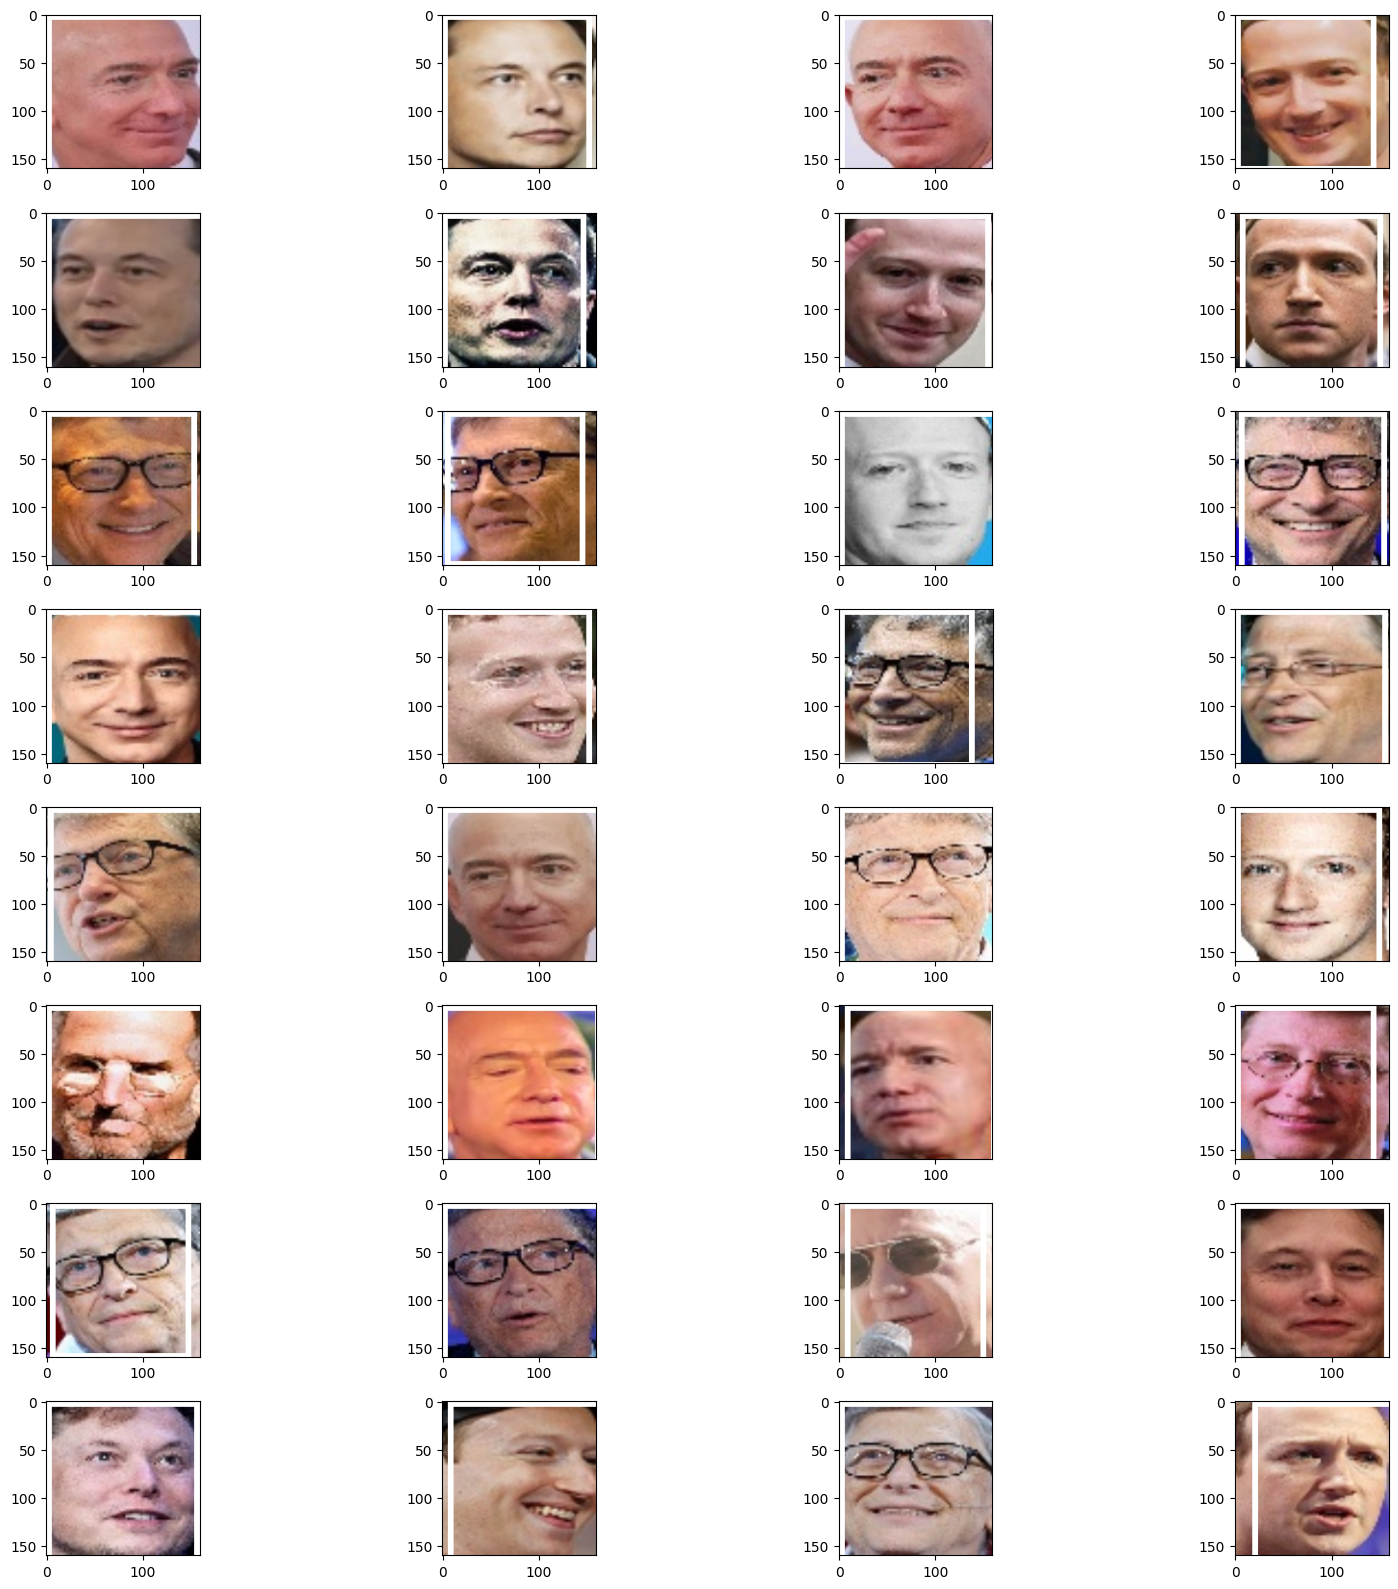

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline 

from PIL import Image, ImageDraw

ncols=4
nrows=int(BATCH_SIZE/ncols)

images, _, boxes = next(iter(mtcnn_visu_loader))

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 16))
fig.tight_layout()

for i in range(nrows):
    for j in range(ncols):
        idx = i*ncols + j
        if idx >= len(images):
            break
        img_draw = images[idx].copy()
        draw = ImageDraw.Draw(img_draw)
        if boxes[idx] is not None:
            box = [max(0.0, p) for p in boxes[idx].tolist()[0]]
            draw.rectangle(box, width=6, outline='white')
        else:
            w, h = img_draw.size
            box = [0.0, 0.0, w, h]
            draw.rectangle(box, width=6, outline='red')
        ax[i][j].imshow(img_draw)
    
plt.show()

In [ ]:
del mtcnn_dataset

Sources:

* https://github.com/timesler/facenet-pytorch/blob/master/examples/finetune.ipynb